# Expression Vector Field (kNN)

Plot vector fields based on OSK expression. Idea is that cells can only move in the direction of decreasing OSK expression over time (assuming all exogenous OSK). Similar to `OSKVectorField.ipynb` but instead use kNN to find neighbors, and assign a direction per cell in the UMAP before averaging.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scanpy as sc
from collections import Counter
import scipy
from tqdm import tqdm

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

### Cluster Config

In [3]:
cluster_config = pd.read_csv("../../figures_factory/configs/cluster.tsv", sep='\t')
cluster_config

,cluster,colour,description,new_cluster
0,1,#B03743,Fibroblast,1
1,2,#E85F6D,Fibroblast-like,3
2,3,#7C2730,Fibroblast-like,2
3,4,#F0A118,Intermediate,12
4,5,#78A824,Pre-iPSC,13
5,6,#A6D854,Pre-iPSC,14
6,7,#F01D35,Fibroblast-like,5
7,8,#13C4A3,iPSC,15
8,9,#406614,Partially-reprogrammed,10
9,10,#D4B81C,Intermediate,9


In [4]:
endo_exo_quants = pd.read_csv("../20211106_sendai_vs_endogenous/out/quants.tsv", sep='\t')
endo_exo_quants

,POU5F1_endo_cts,POU5F1_endo_norm,POU5F1_exo_cts,POU5F1_exo_norm,SOX2_endo_cts,SOX2_endo_norm,SOX2_exo_cts,SOX2_exo_norm,KLF4_endo_cts,KLF4_endo_norm,KLF4_exo_cts,KLF4_exo_norm,MYC_endo_cts,MYC_endo_norm,MYC_exo_cts,MYC_exo_norm
AAACCCAAGAGTGACC-1,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,1.0,0.547864,1.437999e-23,1.049098e-23,0.0,0.000000,0.000000e+00,0.000000e+00
AAACCCAAGTGCCAGA-1,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000e+00,0.000000e+00,2.0,0.964161,7.320248e-17,5.938868e-17
AAACCCACACCATTCC-1,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,1.0,0.526162,1.507851e-17,1.044074e-17,1.0,0.526162,8.043161e-15,5.569285e-15
AAACCCACACGCGTCA-1,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,1.0,0.758320,1.472511e-20,1.670839e-20,0.0,0.000000,0.000000e+00,0.000000e+00
AAACCCAGTCCATAGT-1,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTCACATCCCT-9,1.000000,1.734546,2.108506e-39,9.839039e-39,1.000000,1.734546,1.410664e-32,6.582659e-32,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000e+00,0.000000e+00
TTTGGTTGTTGCCTAA-9,26.705913,2.830634,2.940865e-01,1.618726e-01,7.528468,1.704402,4.715322e-01,2.482110e-01,0.0,0.000000,0.000000e+00,0.000000e+00,2.0,0.786163,2.110357e-15,1.260893e-15
TTTGGTTTCTCTTAAC-9,16.000000,3.279988,2.784124e-10,4.450327e-10,4.892258,2.177034,1.077421e-01,1.589011e-01,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000e+00,0.000000e+00
TTTGTTGGTAGTGTGG-9,19.703674,2.925724,2.963256e-01,2.353929e-01,5.000000,1.700791,8.381753e-08,7.507167e-08,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000e+00,0.000000e+00


## Data

In [5]:
rna = sc.read_h5ad("../20200828_RNA_Seurat/sessions/20210725_n59378/seurat.h5ad")

In [8]:
rna

AnnData object with n_obs × n_vars = 59378 × 29165
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample', 'percent.mt', 'selected', 'percent.oskm', 'RNA_snn_res.1.5', 'seurat_clusters', 'RNA_snn_res.2'
    var: 'name'
    obsm: 'X_pca', 'X_umap'

In [9]:
sc.pp.neighbors(rna)

In [14]:
rna

AnnData object with n_obs × n_vars = 59378 × 29165
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample', 'percent.mt', 'selected', 'percent.oskm', 'RNA_snn_res.1.5', 'seurat_clusters', 'RNA_snn_res.2'
    var: 'name'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [30]:
# make sure in sync
assert(np.all(rna.obs.index == endo_exo_quants.index))

## Vector Field

In [31]:
EXPR = scipy.special.logsumexp(endo_exo_quants[["SOX2_exo_norm", "POU5F1_exo_norm", "KLF4_exo_norm", "MYC_exo_norm"]], axis=1).ravel()

For each cell, take each of its kNN (equally weighted), take the difference of their coordinates in UMAP space to get a direction (normalize it). Compute the average of these vectors by weighting by difference in expression. 

In [37]:
rna.shape

(59378, 29165)

In [38]:
len(EXPR)

59378

array([ 150,  608,  927, 2103, 2503, 5103, 5380, 6270, 7239, 7327, 8844,
       8939, 8978, 9400])

In [53]:
rna.obsm['X_umap'][:10] - rna.obsm['X_umap'][0]

array([[ 0.        ,  0.        ],
       [-0.34066677,  0.26922894],
       [-0.34404469,  1.18441486],
       [ 2.15980259, -1.03262424],
       [ 2.00431424,  0.51258755],
       [-1.01173997,  5.10417891],
       [-1.44933629,  6.07304907],
       [ 1.4061572 , -0.74869823],
       [-0.21798921, -0.50772095],
       [ 3.90905905, -0.95746422]])

In [60]:
(rna.obsm['X_umap'][:10] - rna.obsm['X_umap'][0])

array([[ 0.        ,  0.        ],
       [-0.34066677,  0.26922894],
       [-0.34404469,  1.18441486],
       [ 2.15980259, -1.03262424],
       [ 2.00431424,  0.51258755],
       [-1.01173997,  5.10417891],
       [-1.44933629,  6.07304907],
       [ 1.4061572 , -0.74869823],
       [-0.21798921, -0.50772095],
       [ 3.90905905, -0.95746422]])

In [163]:
cell_umap_dir = []

for i in tqdm(range(len(EXPR))):
    ngb_idxs = np.where(rna.obsp["distances"][i].toarray()!=0)[1]
    weights = -(EXPR[ngb_idxs]- EXPR[i])
    
    weighted_dirs = rna.obsm['X_umap'][ngb_idxs] - rna.obsm['X_umap'][i]
    weighted_dirs = weighted_dirs/np.linalg.norm(weighted_dirs, axis=-1).reshape(-1,1)
    weighted_dirs = weighted_dirs * weights.reshape(-1, 1)
    
    cell_umap_dir.append(weighted_dirs.mean(0))
    
cell_umap_dir = np.array(cell_umap_dir)

100%|██████████| 59378/59378 [00:52<00:00, 1136.90it/s]


In [164]:
cell_umap_dir.shape

(59378, 2)

In [165]:
import sklearn

In [166]:
def umap_discretize(umap, gridsize, discretize=True):
    # min-max normalize and discretize umap
    umap_norm = umap.copy()
    umap_norm -= umap_norm.min(0)
    umap_norm /= umap_norm.max(0)
    umap_norm *= gridsize

    if discretize:
        umap_norm = np.round(umap_norm)
        umap_norm = umap_norm.astype(np.int8)
    
    return umap_norm

def make_vec_field(umap, exprs, directions, gridsize=100, minct=100):
    # umap -> cells x 2 array
    # exprs -> (cells,) array of per cell sendai expression
    # directions -> (cells,2) array of per cell gradient directions
    # gridsize -> number of x and y partitions
    
    expr_grid = np.zeros((gridsize+1, gridsize+1))
    dir_grid = np.zeros((gridsize+1, gridsize+1, 2))
    ct_grid = np.zeros((gridsize+1, gridsize+1))
    
    umap_norm = umap_discretize(umap, gridsize)

    for i,x in enumerate(umap_norm):
        expr_grid[x[0],x[1]] += exprs[i]
        dir_grid[x[0],x[1]] += directions[i]
        ct_grid[x[0],x[1]] += 1
        
    expr_grid[ct_grid>0] /= ct_grid[ct_grid>0]
    dir_grid[ct_grid>0] /= ct_grid[ct_grid>0].reshape(-1,1)
    
    # do this so that arrows don't depend on edges
    # e.g. at edge of cell population aggregate expr is 0
    expr_grid[ct_grid < minct] = np.nan

#     vel_x, vel_y = np.zeros(expr_grid.shape), np.zeros(expr_grid.shape)
    
#     vel_x[:-1] = expr_grid[:-1,:] - expr_grid[1:, :]
#     vel_y[:,:-1] = expr_grid[:,:-1] - expr_grid[:,1:]
        
#     # nans can be now restored
#     vel_x[np.isnan(vel_x)] = 0
#     vel_y[np.isnan(vel_y)] = 0
    
    return dir_grid[:,:,0], dir_grid[:,:,1], expr_grid, ct_grid

In [167]:
GSZ=30
MINCT = 50

In [168]:
vel_x, vel_y, expr_grid, ct_grid = make_vec_field(rna.obsm['X_umap'], 
                                         EXPR, 
                                          cell_umap_dir,
                                         gridsize=GSZ,
                                                 minct=MINCT)

In [169]:
vel_x.shape, vel_y.shape, expr_grid.shape, ct_grid.shape

((31, 31), (31, 31), (31, 31), (31, 31))

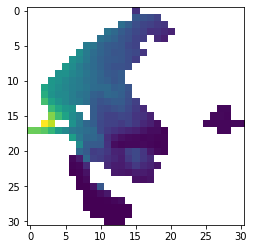

In [170]:
plt.imshow(expr_grid.T[::-1])

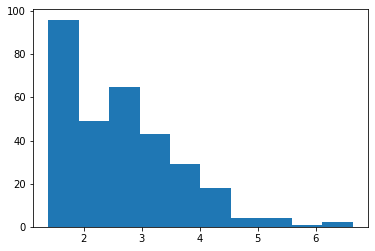

In [171]:
plt.hist(expr_grid.ravel())
plt.show()

In [172]:
# show in regions with reasonable expression of 
vel_x[expr_grid<2] = 0
vel_y[expr_grid<2] = 0

<ipython-input-172-01059304b27e>:2: RuntimeWarning: invalid value encountered in less
  vel_x[expr_grid<2] = 0
<ipython-input-172-01059304b27e>:3: RuntimeWarning: invalid value encountered in less
  vel_y[expr_grid<2] = 0


In [173]:
vel_x[ct_grid<MINCT] = 0
vel_y[ct_grid<MINCT] = 0

In [174]:
CLIP_VEL_QT = 0.95
# clip outliers (typically at edges)
x_abs_upper = np.quantile(np.abs(vel_x.ravel()), CLIP_VEL_QT)
vel_x[vel_x < -x_abs_upper] = -x_abs_upper
vel_x[vel_x > x_abs_upper] = x_abs_upper

y_abs_upper = np.quantile(np.abs(vel_y.ravel()), CLIP_VEL_QT)
vel_y[vel_y < -y_abs_upper] = -y_abs_upper
vel_y[vel_y > y_abs_upper] = y_abs_upper

In [175]:
vel_x.shape

(31, 31)

In [176]:
vel_y.shape

(31, 31)

In [177]:
umap_scaled = umap_discretize(rna.obsm['X_umap'], GSZ, discretize=False)

In [178]:
ct_grid.shape

(31, 31)

(-1.0, 30.0)

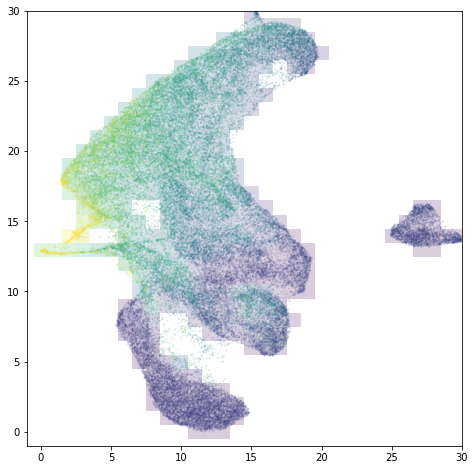

In [179]:
fig, ax = plt.subplots(figsize=(8,8))


# ax.scatter(umap_scaled[:,0],
#            umap_scaled[:,1],
#            c = EXPR,
#            s=1, 
#            alpha=0.1, 
#           vmin=0.5,
#           vmax=np.quantile(EXPR, .98))
ax.imshow(expr_grid.T, alpha=0.2)

ax.scatter(umap_scaled[:,0],
           umap_scaled[:,1],
           c = EXPR,
           s=1, 
           alpha=0.1, 
          vmin=0.5,
          vmax=np.quantile(EXPR, .98))
# plt.title("{} gradient".format(rna.var['name'][GID]), size=16)
plt.xlim(-1, GSZ)
plt.ylim(-1, GSZ)

(-1.0, 30.0)

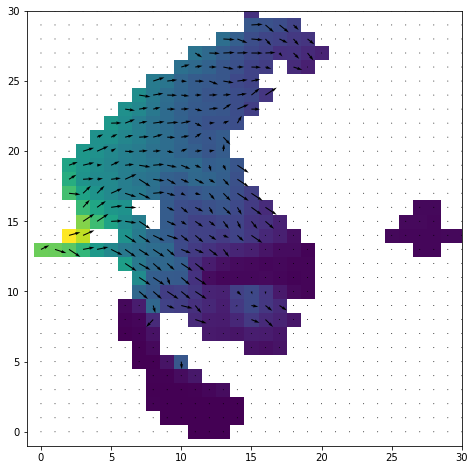

In [180]:
fig, ax = plt.subplots(figsize=(8,8))


# ax.scatter(umap_scaled[:,0],
#            umap_scaled[:,1],
#            c = EXPR,
#            s=1, 
#            alpha=0.1, 
#           vmin=0.5,
#           vmax=np.quantile(EXPR, .98))
ax.imshow(expr_grid.T)

ax.quiver(np.array(range(GSZ+1)), 
              np.array(range(GSZ+1)),
              vel_x.T,
              vel_y.T, 
             color='k',
         scale=3)

# plt.title("{} gradient".format(rna.var['name'][GID]), size=16)
plt.xlim(-1, GSZ)
plt.ylim(-1, GSZ)

(-1.0, 30.0)

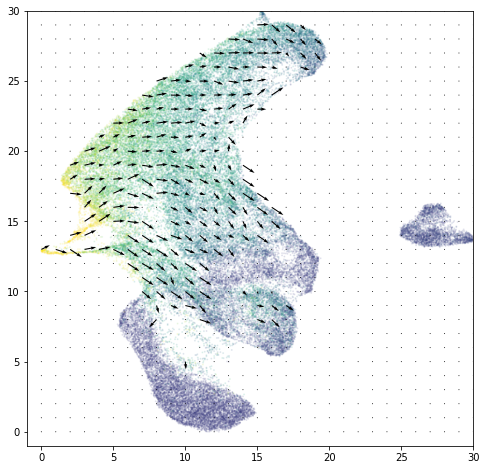

In [181]:
fig, ax = plt.subplots(figsize=(8,8))


ax.scatter(umap_scaled[:,0],
           umap_scaled[:,1],
           c = EXPR,
           s=1, 
           alpha=0.1, 
          vmin=0.5,
          vmax=np.quantile(EXPR, .98))

ax.quiver(np.array(range(GSZ+1)), 
              np.array(range(GSZ+1)),
              vel_x.T,
              vel_y.T, 
             color='k',
         scale=3)

# plt.title("{} gradient".format(rna.var['name'][GID]), size=16)
plt.xlim(-1, GSZ)
plt.ylim(-1, GSZ)

In [182]:
from scipy.ndimage import gaussian_filter

In [183]:
vel_x_smooth = gaussian_filter(vel_x.T, 2)
vel_y_smooth = gaussian_filter(vel_y.T, 2)
speed = np.sqrt((vel_x_smooth**2 + vel_y_smooth**2)/2)

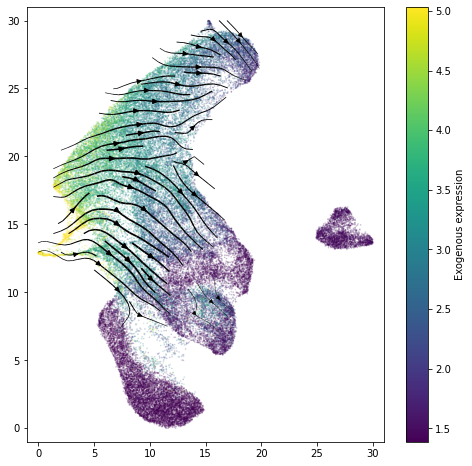

In [184]:
fig, ax = plt.subplots(figsize=(8,8))

cmap = plt.cm.viridis

scatter = ax.scatter(umap_scaled[:,0],
           umap_scaled[:,1],
           c = EXPR,
           s=.5, 
           alpha=.2, 
           cmap=cmap,
          vmin=np.min(EXPR),
          vmax=np.quantile(EXPR, .98),
          rasterized=True)

# create a new ScalarMappable with the original colormap and the correct limits
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=np.min(EXPR), vmax=np.quantile(EXPR, .98)))
sm.set_array([])  # this line is needed for the normalization

# create colorbar using the ScalarMappable
fig.colorbar(sm, ax=ax, orientation='vertical', label='Exogenous expression')


ax.streamplot(np.array(range(GSZ+1)), 
              np.array(range(GSZ+1)),
              vel_x.T,
              vel_y.T, 
              linewidth = 40*speed,
             color='k',
             density=1.5)

# plt.title("{} gradient".format(rna.var['name'][GID]), size=16)
plt.xlim(-1, GSZ+1)
plt.ylim(-1, GSZ+1)


plt.savefig("./sendai_gradient_knn.pdf", height=8, width=8, dpi=300)

---